In [1]:
from numpy import asarray, pi, exp, sqrt
from cv2 import imread
# visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
# progress bar
from tqdm import tqdm_notebook as tqdm

rcParams['figure.figsize'] = 15,10
rcParams['image.cmap'] = 'Greys_r'
%matplotlib inline

In [2]:
im1 = imread('./task1.png',0)
im2 = imread('./task2.jpg',0)

<a id='notebook_top'></a>
[Task 2](#task2)    
[Task 3](#task3)

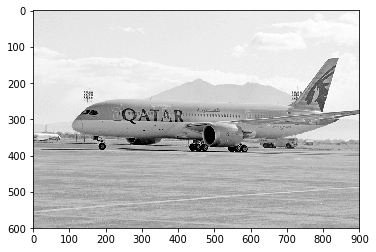

In [3]:
plt.imshow(im1)

### approach 0

In [4]:
def pad(arr):
    if type(arr[0][0]) is list:
        ins = [0,0,0]
    else:
        ins = 0
        
    for row in arr:
        row.insert(0,ins)
        row.append(ins)

    arr.insert(0, [ins for x in arr[0]])
    arr.append([ins for x in arr[0]])

class Kernel():
    def __init__(self, lst):
        self.data = lst
        self.size = len(lst)
        self.middle = self.size // 2
    
    def __getitem__(self,idx):
        return self.data[self.middle - idx[0]][self.middle - idx[1]]
    
    def t(self):
        return Kernel([[k[i] for k in self.data] for i in range(len(self.data))])

def conv0(arr, kernel):
    assert type(arr) is list, "arr should be a list"
    assert type(kernel) is Kernel, "kernel should be of type Kernel"
    kernel_size = kernel.size
    pad_size = kernel_size // 2
    for i in range(pad_size):
        pad(arr)
        
    res = []
    for i in range(pad_size, len(arr) - pad_size):
        res.append([])
        for j in range(pad_size, len(arr[0]) - pad_size):
            c = 0
            for m in range(-pad_size, pad_size + 1):
                for n in range(-pad_size, pad_size + 1):
                    c+= arr[i+m][j+n]*kernel[m,n]
            res[i-pad_size].append(c)
    return res

#### approaches 1,2    
were done before I knew we could not use any numpy functions other then asarray

In [5]:
# def conv(arr, kernel):
#     padding = tuple(np.floor_divide(kernel.shape,2))
#     if len(arr.shape)==3:
#         arr_ = arr.sum(axis=2)
#     else:
#         arr_ = arr
#     arr_p = np.pad(arr_, padding, mode='constant', constant_values=0)
#     temp = np.lib.stride_tricks.as_strided(arr_p, arr_.shape + kernel.shape, arr_p.strides + arr_p.strides)
#     return np.reshape(
#         [(x*kernel[::-1,::-1]).sum() for x in temp.reshape(-1,*kernel.shape)], arr_.shape
#     )

# def conv2(arr, kernel):
#     padding = tuple(np.floor_divide(kernel.shape,2))
#     if len(arr.shape)==3:
#         arr_ = arr.sum(axis=2)
#     else:
#         arr_ = arr
#     arr_p = np.pad(arr_, padding, mode='constant', constant_values=0)
#     temp = np.lib.stride_tricks.as_strided(arr_p, arr_.shape + kernel.shape, arr_p.strides + arr_p.strides)
    
#     return np.sum(
#         [temp[:,:,i,j]*kernel[2-i,2-j] for i in range(kernel.shape[0]) for j in range(kernel.shape[1])],
#         axis=0
#     )

### importing scipy implementation for comparison

In [6]:
from scipy.signal import convolve2d

### post_processing

In [7]:
def post_proc(img):
    max_val = max(map(max, img))
    min_val = min(map(min, img))
    img = asarray(img)
    res1 = (img - min_val) / (max_val - min_val)
    res2 = abs(img)/max(max_val,-min_val)
    return res1,res2

### speed test

In [8]:
kernel = Kernel([[-1,0,1],[-2,0,2],[-1,0,1]])

In [9]:
kern0  = asarray([[-1,0,1],[-2,0,2],[-1,0,1]])

In [10]:
%%time
_ = conv0(im1.tolist(), kernel)

CPU times: user 6.67 s, sys: 19.6 ms, total: 6.69 s
Wall time: 6.69 s


In [11]:
# %%timeit
# conv(im1, kern0)

In [12]:
# %%timeit
# conv2(im1, kern0)

In [13]:
%%timeit
convolve2d(im1, kern0, mode='same')

46 ms ± 4.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### correctness test

In [14]:
# (conv(im1, kernel) == conv2(im1, kernel)).all() and \
# (conv2(im1,kernel) == convolve2d(im1, kernel, mode='same')).all() and \
(convolve2d(im1,kern0,mode='same') == asarray(conv0(im1.tolist(), kernel))).all()

True

### results visualization

In [15]:
Gx = post_proc(conv0(im1.tolist(),kernel))
Gy = post_proc(conv0(im1.tolist(),kernel.t()))

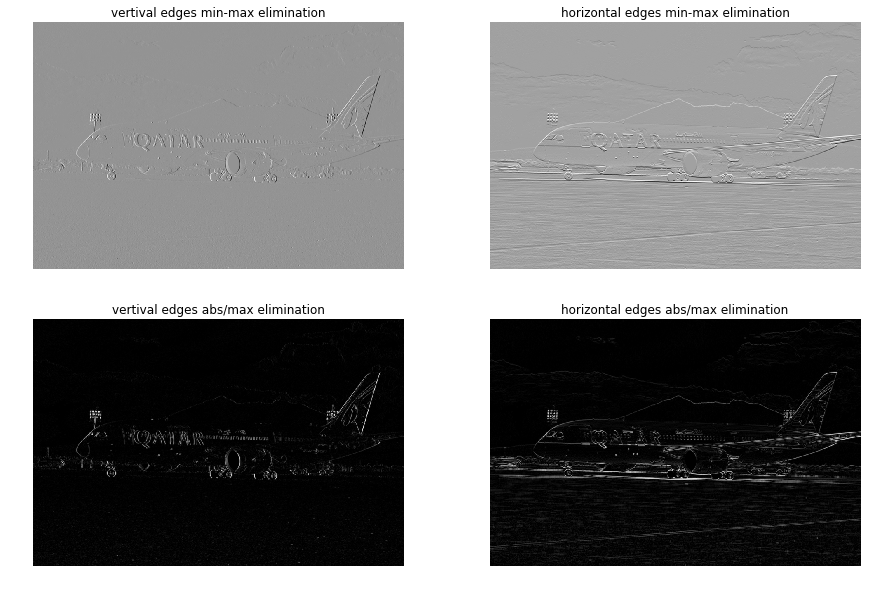

In [16]:
f,ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].imshow(Gx[0], cmap='Greys_r')
ax[0,0].set_title('vertival edges min-max elimination')
ax[0,1].imshow(Gy[0], cmap='Greys_r')
ax[0,1].set_title('horizontal edges min-max elimination')

ax[1,0].imshow(Gx[1], cmap='Greys_r')
ax[1,0].set_title('vertival edges abs/max elimination')
ax[1,1].imshow(Gy[1], cmap='Greys_r')
ax[1,1].set_title('horizontal edges abs/max elimination')

for a in ax.ravel():
    a.axis('off')

---
### Task 2
<a id='task2'></a>
[go to the top](#notebook_top)

(-0.5, 749.5, 457.5, -0.5)

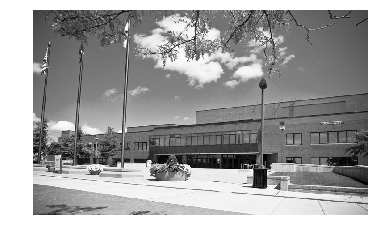

In [17]:
plt.imshow(im2)
plt.axis('off')

In [18]:
octaves = {
    1: [1/sqrt(2), 1, sqrt(2), 2, 2*sqrt(2)],
    2: [sqrt(2), 2, 2*sqrt(2), 4, 4*sqrt(2)],
    3: [2*sqrt(2), 4, 4*sqrt(2), 8, 8*sqrt(2)],
    4: [4*sqrt(2), 8, 8*sqrt(2), 16, 16*sqrt(2)]
}

---

computing DoGs

In [19]:
def Gauss(sigma):
    def f(x,y):
        return 1/(2*pi*sigma**2)*exp(-(x**2+y**2)/(2*sigma**2))
    return f

def np_meshgrid(rng):
    X = [list(rng) for x in range(len(rng))]
    Y = [[k[i] for k in X] for i in range(len(X))]
    return asarray(X),asarray(Y)

def normalize(x):
    return x / sum(sum(x))

def GKernel(sigma,size=7):
    return Kernel(
        normalize(
            Gauss(sigma)(*np_meshgrid(range(-size//2+1,size//2+1)))
        )
    )

def pyraimd_up(img):
    if type(img) is list:
        return asarray(img)[::2,::2].tolist()
    else:
        return img[::2,::2]

X,Y = np_meshgrid(range(-3,4))

In [20]:
img_pyramid = [im2]
for i in range(3):
    img_pyramid.append(pyraimd_up(img_pyramid[-1]))

In [21]:
len(img_pyramid)

4

In [22]:
oct_images = {
    d[0]: [conv0(img.tolist(), GKernel(sigma)) for sigma in tqdm(d[1])] for d,img in zip(octaves.items(), img_pyramid)
}

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [88]:
asarray(oct_images[2][0]).shape

(229, 375)

In [89]:
asarray(oct_images[3][0]).shape

(115, 188)

Text(0.5,1,'Octave 3 image 1 (sigma=2sqrt(2), resolution=(115, 188))')

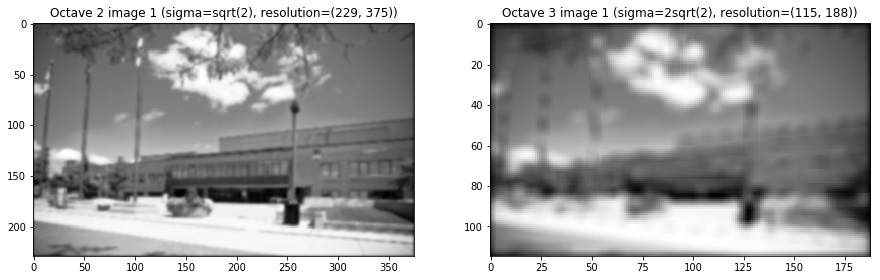

In [90]:
f,ax = plt.subplots(1,2,figsize=(15,10))
ax[0].imshow(oct_images[2][0])
ax[0].set_title('Octave 2 image 1 (sigma=sqrt(2), resolution=(229, 375))')

ax[1].imshow(oct_images[3][0])
ax[1].set_title('Octave 3 image 1 (sigma=2sqrt(2), resolution=(115, 188))')

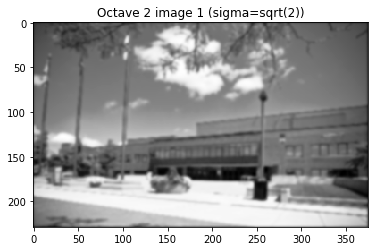

In [81]:
plt.title('Octave 2 image 1 (sigma=sqrt(2))')
plt.imshow(oct_images[2][0])

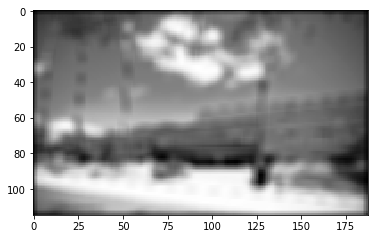

In [80]:
plt.imshow(oct_images[3][0])

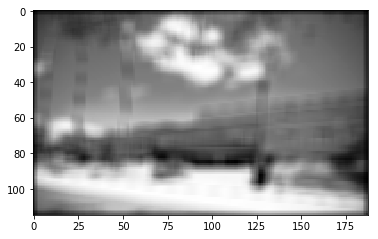

In [25]:
plt.imshow(oct_images[3][3])

In [26]:
def DoG(oct_images):
    return {
        k: [asarray(im1) - asarray(im0) for im0,im1 in zip(ar[:-1],ar[1:])] for k, ar in oct_images.items()
    }

In [27]:
dogs = DoG(oct_images)

Text(0.5,1,'Octave 3, DoG 4')

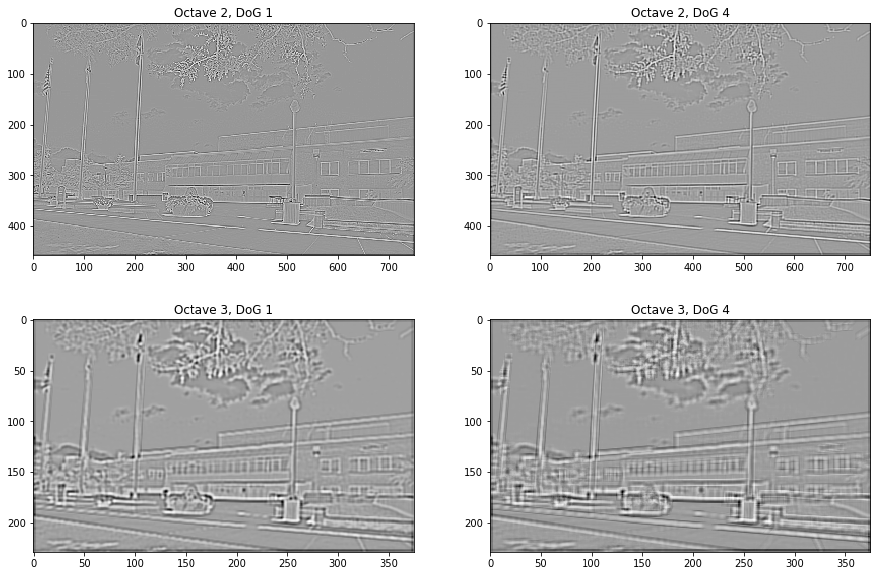

In [91]:
f,ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].imshow(
    dogs[1][0], cmap='Greys_r'
)
ax[0,0].set_title('Octave 2, DoG 1')
ax[0,1].imshow(
    dogs[1][3], cmap='Greys_r'
)
ax[0,1].set_title('Octave 2, DoG 4')
ax[1,0].imshow(
    dogs[2][0], cmap='Greys_r'
)
ax[1,0].set_title('Octave 3, DoG 1')
ax[1,1].imshow(
    dogs[2][3], cmap='Greys_r'
)
ax[1,1].set_title('Octave 3, DoG 4')

finding keypoints

In [29]:
def ravel(arr):
    return [x for y in arr for x in y]

def check_point(subdogs, i,j):
    val = subdogs[1][i,j]
    si = slice(i-1,i+2)
    sj = slice(j-1,j+2)
    
    lvls = [ravel(s[si,sj].tolist()) for s in subdogs]
    lvls[1].pop(4) #popping the value itself
    candidates = ravel(lvls)
    min_ = min(candidates)
    max_ = max(candidates)
    return (val > max_) | (val < min_)

def find_keypoints(triplet):
    h,w = triplet[0].shape
    res = [[]]
    for i in range(1,h-1):
        for j in range(1,w-1):
            res[i-1].append(check_point(triplet,i,j))
        res.append([])
    res.pop()
    pad(res);
    return res

In [30]:
oct_keypoints = {
    k: [asarray(find_keypoints(d[i:i+3])) for i in range(2)] for k,d in tqdm(dogs.items())
}

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [94]:
oct_keypoints.keys()

dict_keys([1, 2, 3, 4])

(-0.5, 374.5, 228.5, -0.5)

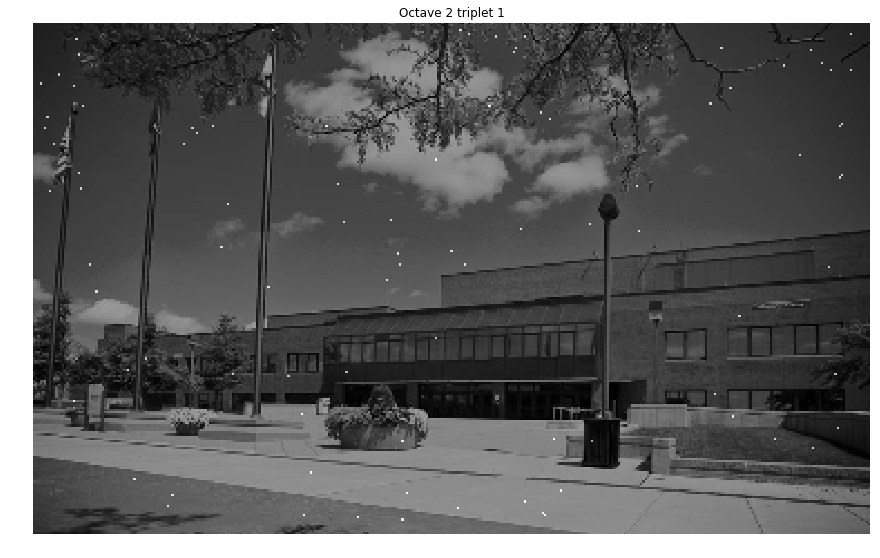

In [96]:
plt.figure(figsize=(15,10))
plt.imshow(
    img_pyramid[1] + oct_keypoints[2][1]*255, cmap='Greys_r'
)
plt.title("Octave 2 triplet 1")
plt.axis('off')

(-0.5, 187.5, 114.5, -0.5)

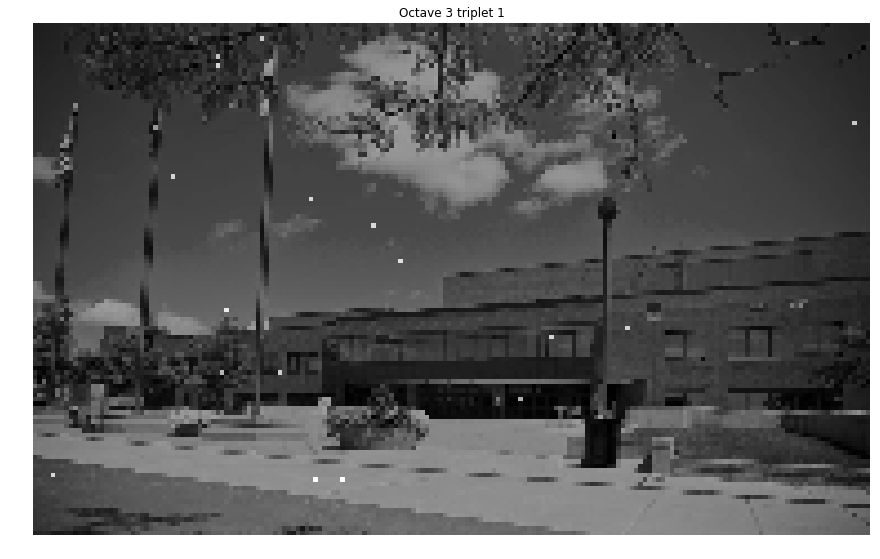

In [97]:
plt.figure(figsize=(15,10))
plt.imshow(
    img_pyramid[2] + oct_keypoints[3][0]*255, cmap='Greys_r'
)
plt.title("Octave 3 triplet 1")
plt.axis('off')

### report making

(1) include images of the second and third octave and specify their resolution (width ×
height, unit pixel);    
(2) include DoG images obtained using the second and third octave;    
(3) clearly show all the detected keypoints using white dots on the original image    
(4) provide coordinates of the five left-most detected keypoints (the origin is set to be the top-left corner)

(229, 375)
(115, 188)


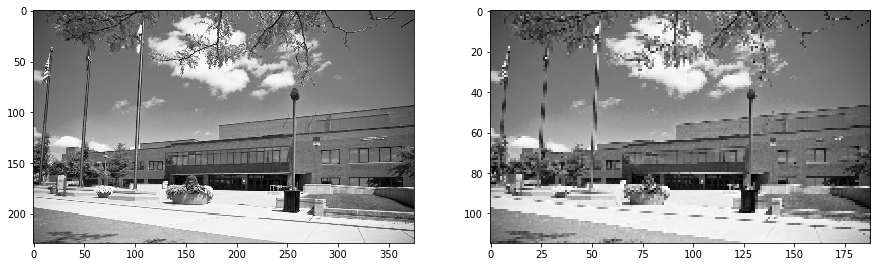

In [33]:
# 1
print(img_pyramid[1].shape)
print(img_pyramid[2].shape)
f,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].imshow(img_pyramid[1])
ax[1].imshow(img_pyramid[2])

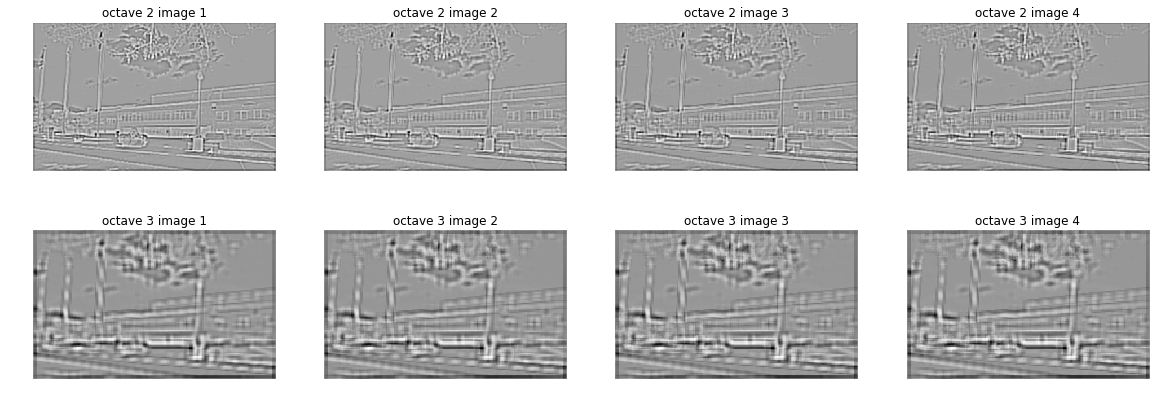

In [34]:
# 2
f,ax = plt.subplots(2,4,figsize=(20,7))
for j in (2,3):
    for i in range(4):
        ax[j-2,i].imshow(dogs[j][i])
        ax[j-2,i].set_title(f"octave {j} image {i+1}")
        ax[j-2,i].axis('off')

In [35]:
def plot_kp(ax,img,keypoints,c='r'):
    tmp = (img.copy()*0.5).astype('uint8') # darkening image to 
    tmp = asarray([tmp,tmp,tmp]).transpose(1,2,0)
    if c == 'r':
        p = [255,0,0]
    else:
        p = [255,255,255]
    
    tmp[keypoints == 1] = p
    plt.figure(figsize=(15,10))
    ax.imshow(tmp)

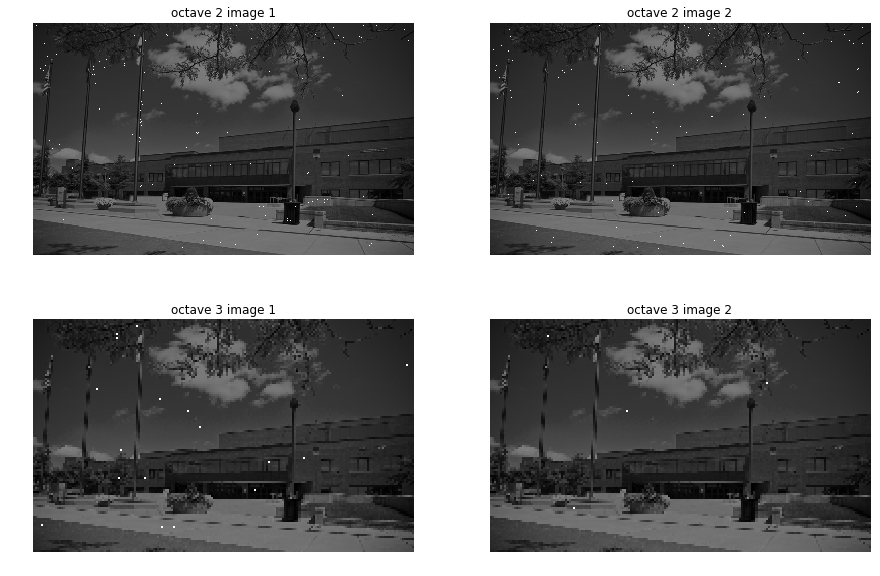

In [36]:
# 3
f,ax = plt.subplots(2,2,figsize=(15,10))
for j in (2,3):
    for i in range(2):
        plot_kp(ax[j-2,i], img_pyramid[j-1], oct_keypoints[j][i],c='w')
        ax[j-2,i].set_title(f"octave {j} image {i+1}")
        ax[j-2,i].axis('off')
plt.show();

In [37]:
# 4
from numpy import argwhere #used just for report, so hope it's OK


def find_leftmost(kp):
    locs = argwhere(kp)
    return asarray(sorted(locs, key=lambda x: x[1])[:5])

In [38]:
find_leftmost(oct_keypoints[2][0])

array([[ 3,  3],
       [45,  7],
       [47, 10],
       [21, 11],
       [42, 12]])

In [39]:
find_leftmost(oct_keypoints[2][1])

array([[27,  3],
       [47,  5],
       [42,  6],
       [75,  7],
       [54,  9]])

In [40]:
find_leftmost(oct_keypoints[3][0])

array([[101,   4],
       [ 34,  31],
       [  7,  41],
       [  9,  41],
       [ 78,  42]])

In [41]:
find_leftmost(oct_keypoints[3][1])

array([[  8,  28],
       [ 93,  41],
       [ 45,  67],
       [ 31, 136]])

---
### Task3
<a id='task3'></a>
[go to the top](#notebook_top)

In [42]:
import numpy as np
import cv2
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from matplotlib.patches import Rectangle

In [71]:
img_names = !ls ./task3 | grep jpg | grep -v template #no sure if that works on Windows, so here's a dirty hack

In [72]:
#need to preserve the order because I crop templates from img[i]
img_names = ['neg_10.jpg', 'neg_1.jpg', 'neg_2.jpg', 'neg_3.jpg', 'neg_4.jpg', 'neg_5.jpg', 'neg_6.jpg', 'neg_8.jpg', 'neg_9.jpg', 'pos_10.jpg', 'pos_11.jpg', 'pos_12.jpg', 'pos_13.jpg', 'pos_14.jpg', 'pos_15.jpg', 'pos_1.jpg', 'pos_2.jpg', 'pos_3.jpg', 'pos_4.jpg', 'pos_5.jpg', 'pos_6.jpg', 'pos_7.jpg', 'pos_8.jpg', 'pos_9.jpg']

In [44]:
imread = lambda x: cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2HSV)[:,:,2]

In [45]:
imgs = [imread('./task3/'+i) for i in img_names]

Attempt to create a custom template matching function that accepts background mask    
Worked very slowly and did not show much performance improvement

In [46]:
# def match_template(image, template, mask):
#     """performs masked correlation matching"""
#     shape = tuple(np.subtract(image.shape,template.shape))
#     im_r = np.lib.stride_tricks.as_strided(image, shape+template.shape, image.strides + image.strides)
#     ccor = (
#         (im_r - im_r.mean(axis=(2,3))[:,:,np.newaxis,np.newaxis]) * (template - template.mean())[np.newaxis,np.newaxis,:,:] * mask[np.newaxis,np.newaxis,:,:]
#     ).sum(axis=(2,3))
#     ccor[ccor < 0] = 0
#     ccor = ccor / ccor.max()
#     res = cv2.minMaxLoc(ccor)
#     return res[1], res[3]

# def match_template2(image, template, mask):
#     """normalizes image batch-wise and performs masked correlation matching"""
#     shape = tuple(np.subtract(image.shape,template.shape))
#     im_r = np.lib.stride_tricks.as_strided(image, shape+template.shape, image.strides + image.strides) * mask[np.newaxis, np.newaxis,:,:]
    
#     im_r = im_r - im_r.min(axis=(2,3))[:,:,np.newaxis,np.newaxis]
#     im_r = im_r / (im_r.max(axis=(2,3)) + 0.1)[:,:,np.newaxis,np.newaxis]
    
#     template = template - template.min()
#     template = template / template.max() + 0.1
    
#     ccor = (
#         (im_r - im_r.mean(axis=(2,3))[:,:,np.newaxis,np.newaxis]) * (template - template.mean())[np.newaxis,np.newaxis,:,:] * mask[np.newaxis,np.newaxis,:,:]
#     ).sum(axis=(2,3))
#     ccor[ccor < 0] = 0
#     ccor_max = ccor.max()
#     ccor = ccor / ccor_max
#     return ccor_max, cv2.minMaxLoc(ccor)[3]

# helper = lambda im, mask, scale: (cv2.resize(im, None, fx=scale, fy=scale), cv2.resize(mask, None, fx=scale, fy=scale))

# def find_cursor(image, template, mask):
#     scale_range = np.linspace(0.8,1.1,num=8)
#     matches = [match_template2(image,*helper(template, mask, scale)) for scale in tqdm(scale_range)]
#     confidence = [x[0] / s**2 for x,s in zip(matches, scale_range)]
#     loc = [x[1] for x in matches]
#     mode = Counter(loc).most_common()
#     return mode[0], (confidence, loc)

### DoG approach

In [47]:
def doggo(im_v):
    return cv2.GaussianBlur(im_v, (5,5), 8*np.sqrt(2)).astype('float32') - cv2.GaussianBlur(im_v, (5,5), 3*np.sqrt(2))

def find_candidates(img, sc_temps, template_shape):
    dog = doggo(img)
    locs = [cv2.minMaxLoc(
                cv2.matchTemplate(dog, tmp, cv2.TM_CCORR_NORMED)
            )[3] for tmp in sc_temps]
    shapes = [s.shape for s in sc_temps]
    matches = [
        cv2.resize(
            img[l[1]:l[1]+s[0],l[0]:l[0]+s[1]], template_shape[::-1]
        ) for l,s in zip(locs, shapes)
    ]
    
    std = [(l,m.std()) for l,m in zip(locs, matches)]
    
    return locs, matches

def find_best_one(template, locs, matches, accept_threshold = 4500):
    sobel11 = cv2.Sobel(template, 2, 1, 1) # this is where one would use some classifier over some features
    sobel10 = cv2.Sobel(template, 2, 1, 0) # but here we are keeping things simple
    canny_t = cv2.Canny(template, 10, 100)
    # this particular features were developed for the first template, but for interest I've decided to check
    # how they perform on other templates
    # as it turned out works well for arrow-like templates
    canny_t[0,:] = 0 #masking background
    canny_t[:,0] = 0
    
    # just checking how much "contour" intersection we have on candidate and template 
    s_score_func = lambda x: (
        cv2.Sobel(x,2,1,0) & sobel10
    ).sum() * 0.5 + (
        cv2.Sobel(x,2,1,1) & sobel11
    ).sum() * 0.5
    
    c_score_func = lambda x: (cv2.Canny(x, 10, 100) & canny_t).sum()
    
    s_scores = [s_score_func(x) for x in matches]
    c_scores = [c_score_func(x) for x in matches]
    
    # Canny results in {0,255} images so the score is always higher
    # using weights to mitigate that
    scores = [ss*0.6+cs*0.4 for ss,cs in zip(s_scores, c_scores)]
    best = np.argmax(scores)
    
    return (locs[best], matches[best], scores[best]) if scores[best] > accept_threshold else None 

def plot(image, detect_res=None, template_shape=(15,10)):
    f,ax = plt.subplots(1,1,figsize=(20,10))
    ax.imshow(image, cmap='Greys_r')
    if detect_res:
        loc = detect_res[0]
        ax.add_patch(
            Rectangle((loc[0],loc[1]), *template_shape[::-1],
                      linewidth=1, edgecolor='r', facecolor='none')
        )
    else:
        print("Nothing detected")
    return f,ax

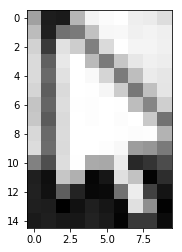

In [48]:
# cropping a tight template from one of the images
template = doggo(imgs[10])[273:288,865:875]
templ_orig = imgs[10][273:288,865:875]

sc_temps = [cv2.resize(template,None, fx=s, fy=s) for s in np.linspace(0.7, 1.1, 16)]
plt.imshow(templ_orig)

In [101]:
res = [
    find_best_one(templ_orig, *find_candidates(img, sc_temps, template.shape)) for img in tqdm(imgs)
]

HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

### checking the results

In [105]:
i = -1 # you probably know how this image iteration method works

pos_1.jpg


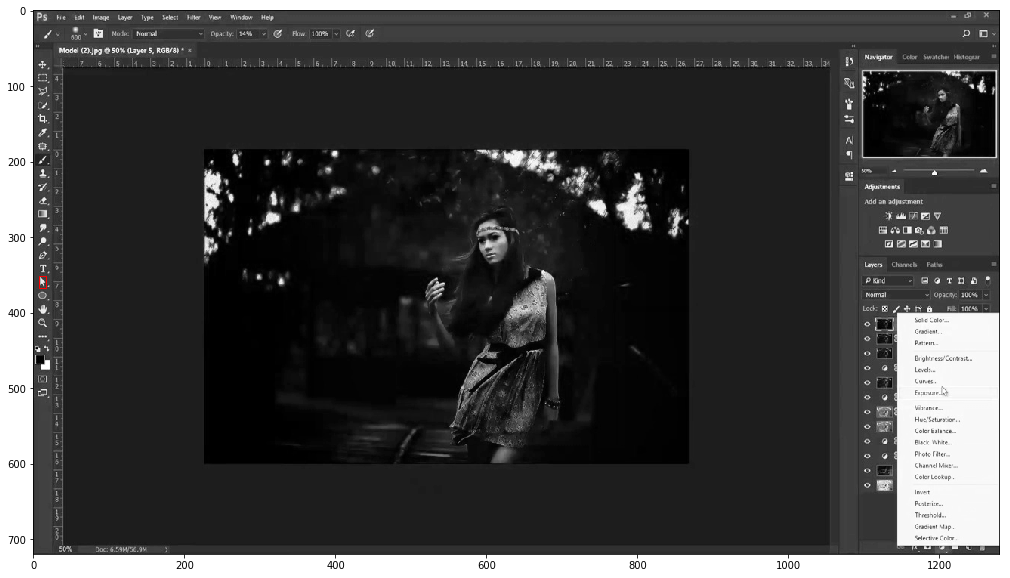

In [121]:
i += 1
if i<len(res):
    print(img_names[i])
    plot(imgs[i],res[i])
else:
    print("end")

### Bonus
sorry for the mess

In [122]:
imgs_new = !ls ./task3b/

In [123]:
# once again, need to make sure that the order is preserved
imgs_new = ['neg_10.jpg', 'neg_11.jpg', 'neg_12.jpg', 'neg_1.jpg', 'neg_2.jpg', 'neg_3.jpg', 'neg_4.jpg', 'neg_5.jpg', 'neg_6.jpg', 'neg_8.jpg', 'neg_9.jpg', 't1_1.jpg', 't1_2.jpg', 't1_3.jpg', 't1_4.jpg', 't1_5.jpg', 't1_6.jpg', 't2_1.jpg', 't2_2.jpg', 't2_3.jpg', 't2_4.jpg', 't2_5.jpg', 't2_6.jpg', 't3_1.jpg', 't3_2.jpg', 't3_3.jpg', 't3_4.jpg', 't3_5.jpg', 't3_6.jpg']

In [124]:
t1 = [imread('./task3b/'+x) for x in imgs_new if 't1' in x]
t2 = [imread('./task3b/'+x) for x in imgs_new if 't2' in x]
t3 = [imread('./task3b/'+x) for x in imgs_new if 't3' in x]
neg = [imread('./task3b/'+x) for x in imgs_new if 'neg' in x]

In [125]:
templ1_orig = t1[0][346:369,1111:1131]
templ1 = doggo(t1[0])[346:369,1111:1131]
sc_temps1 = [cv2.resize(templ1,None, fx=s, fy=s) for s in np.linspace(0.7, 1.1, 16)]

In [126]:
test_images = t1 + neg + t2

In [127]:
res = [
    find_best_one(templ1_orig, *find_candidates(img, sc_temps1, templ1.shape), accept_threshold=8000) for img in tqdm(test_images)
]

HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

In [57]:
i=-1

In [58]:
# it's interesting how the scale on the first image is different, but we still have a match 

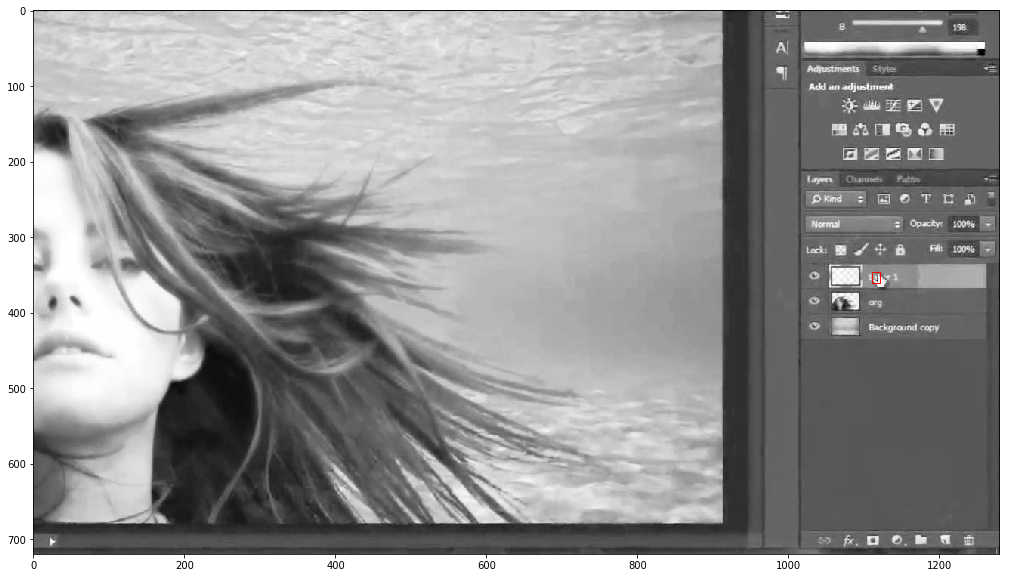

In [59]:
i += 1
if i<len(res):
    plot(test_images[i],res[i])
else:
    print("end")

In [134]:
templ2_orig = t2[0][460:485,615:638]
templ2 = doggo(t2[0])[460:485,615:638]
sc_temps2 = [cv2.resize(templ2,None, fx=s, fy=s) for s in np.linspace(0.7, 1.1, 16)]

In [135]:
test_images = t2 + neg + t1 # redefined to first see most relevant images and also to save time

In [136]:
res = [
    find_best_one(templ2_orig, *find_candidates(img, sc_temps2, templ2.shape), accept_threshold=10600) for img in tqdm(test_images)
]

HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

In [63]:
i=-1

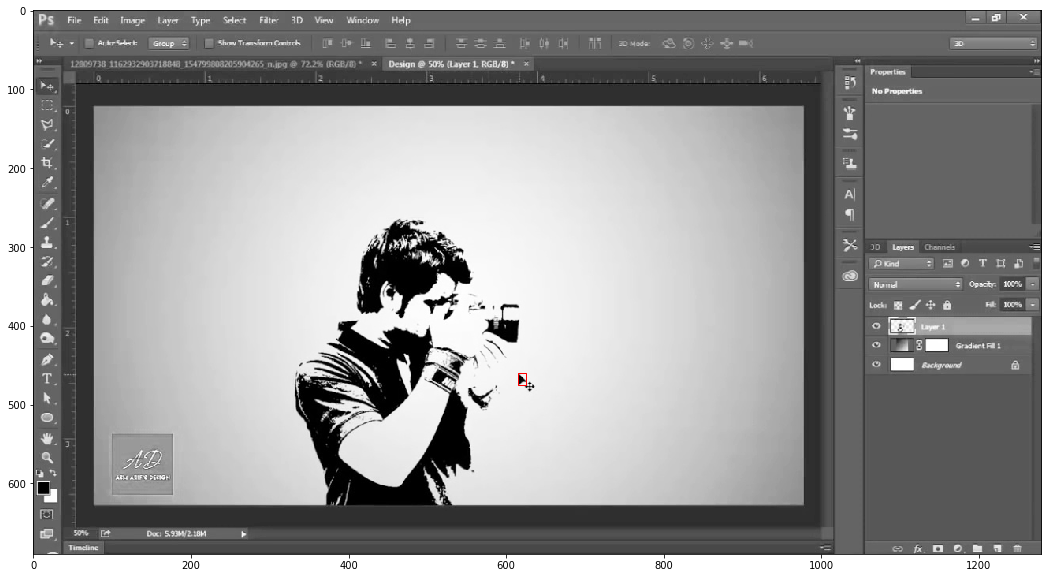

In [64]:
i += 1
if i<len(res):
    plot(test_images[i],res[i])
else:
    print("end")

In [65]:
templ3_orig = t3[0][275:295,852:866]
templ3 = doggo(t3[0])[275:295,852:866]
sc_temps3 = [cv2.resize(templ3,None, fx=s, fy=s) for s in np.linspace(0.7, 1.1, 16)]

In [138]:
test_images = t3 + neg + t1

In [139]:
res = [
    find_best_one(templ3_orig, *find_candidates(img, sc_temps3, templ3.shape), accept_threshold=7900) for img in tqdm(test_images)
]

HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

In [68]:
i = -1

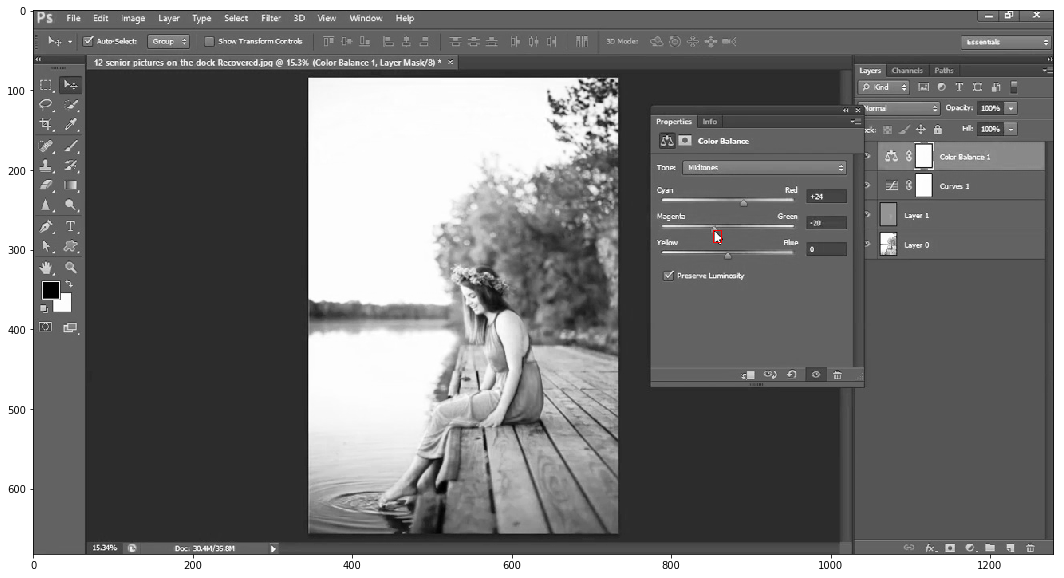

In [69]:
i += 1
if i<len(res):
    plot(test_images[i],res[i])
else:
    print("end")